# Options Payoff

In [1]:
import os
os.chdir(os.path.pardir)
os.chdir(os.path.pardir)

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot

from copy import copy
from src.market.option import CallOptionMarket, PutOptionMarket
from src.market_actor.stub import MarketActorStub
from src.market_listener.stub import MarketListenerStub
from src.price_model.gbm import GBMPriceModel
from src.portfolio import Portfolio

In [3]:
%matplotlib inline

In [4]:
asset_ticker = "CVNA"
expiry_datetime = datetime.datetime(2023, 2, 10)

asset_spot_price = 7.77
asset_ret_drift = .2
asset_volatility = 2.08
risk_free_rate = .06
transact_cost_percent = 1

price_model = GBMPriceModel(
    [asset_ticker],
    [asset_spot_price],
    [asset_ret_drift],
    np.array([[asset_volatility ** 2]]),
    risk_free_rate,
    time_step_size=1,
    log_ret_values=True
)

price_model.time_step_size = price_model.get_time_to_expiry(expiry_datetime) \
        - 86400 / price_model.base_unit_of_time

price_model.time_step_size

0.02881240880485517

In [5]:
# Option chain
option_chain = {
    7.0: ((1.17, 1.20), (0.46, 0.50)),
    7.5: ((0.88, 0.97), (0.70, 0.76)),
    8.0: ((0.73, 0.74), (0.98, 1.05)),
    8.5: ((0.54, 0.60), (1.32, 1.42)),
}

call_markets = {
    strike_price: CallOptionMarket(f"C{strike_price}", "USD", asset_ticker,
            strike_price, expiry_datetime)
    for strike_price in option_chain
}

put_markets = {
    strike_price: PutOptionMarket(f"C{strike_price}", "USD", asset_ticker,
            strike_price, expiry_datetime)
    for strike_price in option_chain
}

In [6]:
# Portfolio generating function
def make_portfolio(*order_params: tuple[(CallOptionMarket | PutOptionMarket), float, float]) \
    -> tuple[Portfolio, float]:
    market_actor = MarketActorStub(transact_var_cost_rate_percent=transact_cost_percent)

    for market, price, size in order_params:
        order = market_actor.make_order(market, price, size)
        market_actor.execute_order(order)

    cash_offset = market_actor.portfolio.get_size("USD")
    market_actor.portfolio.remove("USD")

    return market_actor.portfolio, cash_offset

### Bull Call Spread

In [7]:
bull_call_port, bull_call_offset = make_portfolio(
    (call_markets[7.5], option_chain[7.5][0][1], 1),
    (call_markets[8.5], option_chain[8.5][0][0], -1)
)

bull_call_price_dist = bull_call_port.get_price_dist(price_model)
bull_call_ret_dist = bull_call_port.get_ret_dist(price_model)

Submitted buy order of 1.00 C7.5       at 0.97
Filled buy order of 1.00 C7.5       at 0.97
Submitted sell order of 1.00 C8.5       at 0.54
Filled sell order of 1.00 C8.5       at 0.54


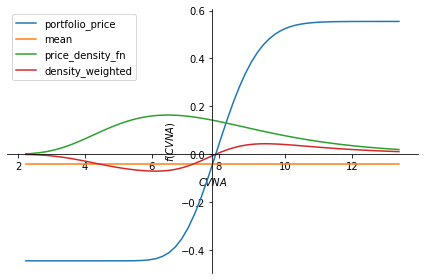

In [8]:
bull_call_price_dist.plot(tail_percentile=.025, density_weighted=True, offset=bull_call_offset)

## Neutral Strategies

### Butterfly Spread

In [9]:
butterfly_port, butterfly_offset = make_portfolio(
    (call_markets[7.5], option_chain[7.5][0][1], 1),
    (call_markets[8.0], option_chain[8.0][0][0], -2),
    (call_markets[8.5], option_chain[8.5][0][1], 1))

butterfly_price_dist = butterfly_port.get_price_dist(price_model)
butterfly_ret_dist = butterfly_port.get_ret_dist(price_model)

Submitted buy order of 1.00 C7.5       at 0.97
Filled buy order of 1.00 C7.5       at 0.97
Submitted sell order of 2.00 C8.0       at 0.73
Filled sell order of 2.00 C8.0       at 0.73
Submitted buy order of 1.00 C8.5       at 0.60
Filled buy order of 1.00 C8.5       at 0.60


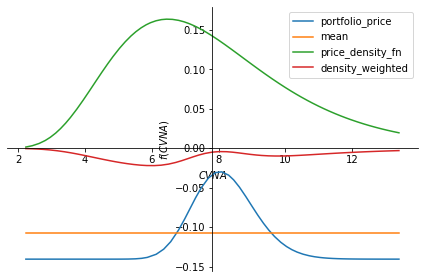

In [10]:
butterfly_price_dist.plot(tail_percentile=.025, density_weighted=True, offset=butterfly_offset)

In [ ]:
# Sharpe ratio of naive portfolio
(bull_call_ret_dist.get_expectation() - np.exp(price_model.get_risk_free_rate()
        * price_model.get_time_step_size()) + 1) \
        / np.sqrt(bull_call_ret_dist.get_variance())

In [ ]:
from src.portfolio.optimizer.tangent import TangentPortfolioOptimizer

tangent_opt = TangentPortfolioOptimizer(price_model)
opt_weights = tangent_opt.get_optimized_weights(portfolio)

opt_weights

In [ ]:
tangent_opt.apply_weights(portfolio, opt_weights)

opt_port_price_dist = portfolio.get_price_dist(price_model)
opt_port_ret_dist = portfolio.get_ret_dist(price_model)

In [ ]:
opt_port_price_dist.plot(tail_percentile=.025, density_weighted=True)

In [ ]:
opt_port_ret_dist.plot(tail_percentile=.025, density_weighted=True)

In [ ]:
opt_port_ret_dist.get_expectation()

In [ ]:
opt_port_ret_dist.get_variance()

In [ ]:
# Sharpe ratio of tangent portfolio
# Negative sharpe ratio implies shorting the tangent portfolio
(opt_port_ret_dist.get_expectation() - np.exp(price_model.get_risk_free_rate()
        * price_model.get_time_step_size()) + 1) \
        / np.sqrt(opt_port_ret_dist.get_variance())